In [1]:
import sys
sys.path.append('/opt/ml/code')

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from my_modules.transform import get_transform
from my_modules.dataset import TrainDataset, EvalDataset
from my_modules.trainer import Trainer
from my_modules.loss import LabelSmoothing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models

from efficientnet_pytorch import EfficientNet

In [2]:
## seeds

random_seed = 42

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [16]:
## hyperparameters

model_name = 'efficientnet-b3' #'tf_efficientnetv2_b3' # 'efficientnet-b0'
device = 'cuda'
batch_size = 64
target = 'gender'
fold = 5

df_train_path = f'df/fold/df_train_fold{fold}.csv'
df_valid_path = f'df/fold/df_valid_fold{fold}.csv'
#df_test_path = '/opt/ml/input/data/eval/info.csv'

df_train = pd.read_csv(df_train_path)
df_valid = pd.read_csv(df_valid_path)
#df_test = pd.read_csv(df_test_path)

In [17]:
input_size = EfficientNet.get_image_size(model_name)
print(input_size)

300


In [34]:
## transform

transform_valid = get_transform(augment=False, crop=300, resize=input_size, cutout=None)

In [35]:
## prepare dataset

valid_dataset = TrainDataset(df=df_valid, transform=transform_valid, target=target)
#valid_dataset = TrainDataset(df=df_valid, transform=transform_valid, target=target)

In [36]:
## prepare dataloader

dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=3, drop_last=False, shuffle=False)

In [8]:
## prepare model

if model_name.startswith('efficientnet'):
    model = EfficientNet.from_pretrained(model_name, num_classes=2 if target=='gender' else 3)
elif model_name.startswith('tf'):
    import timm
    model = timm.create_model('tf_efficientnetv2_b3', pretrained=True, num_classes=2 if target=='gender' else 3)
else:
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
    
model.to(device)
print(model_name, 'ready')

Loaded pretrained weights for efficientnet-b3
efficientnet-b3 ready


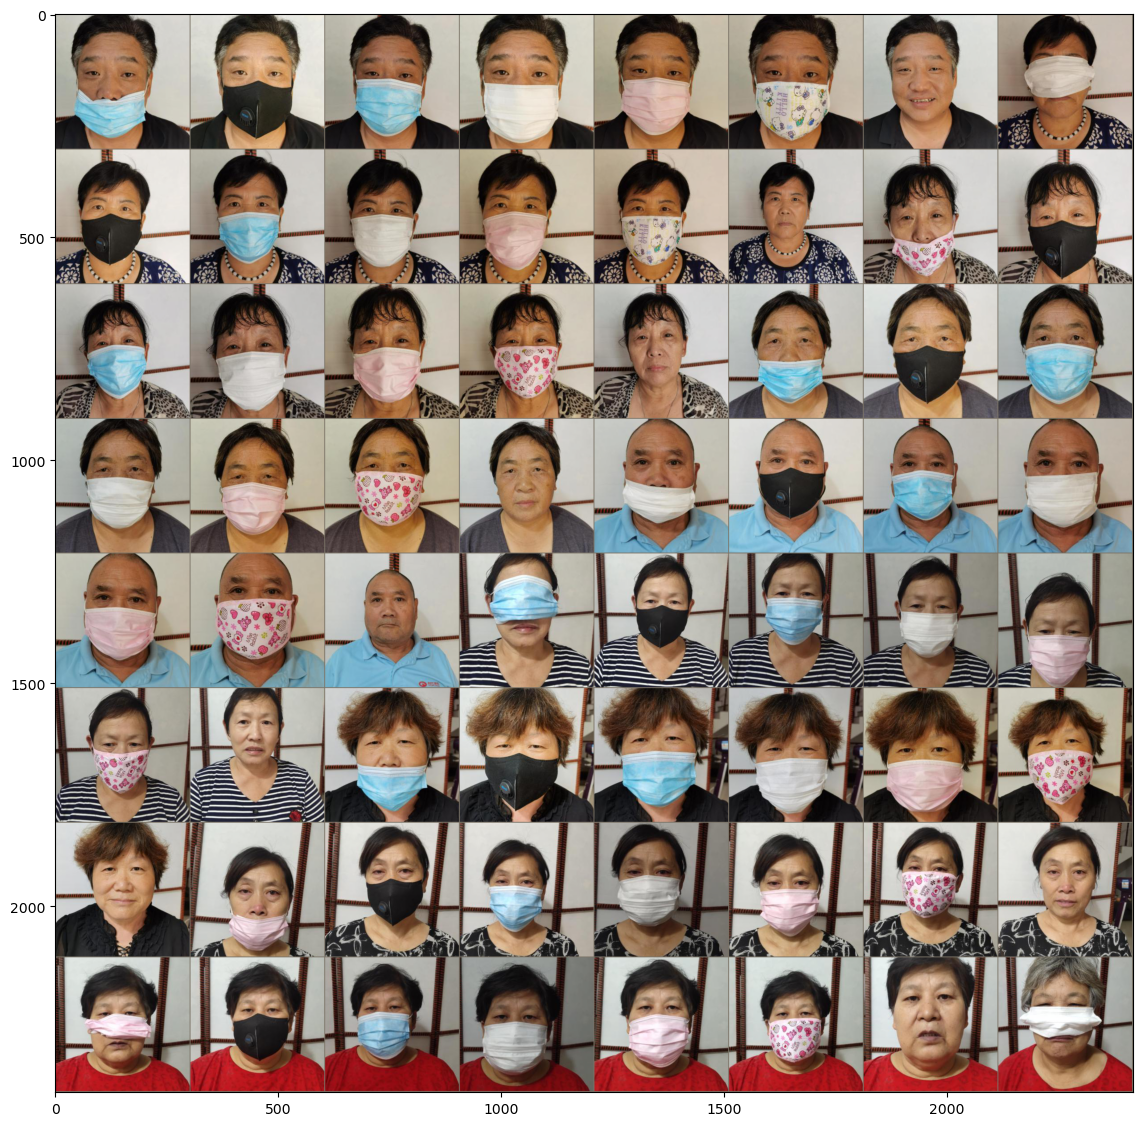

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [38]:
# check input train batch

from my_modules.utils import imshow
batch = next(iter(dataloader))
imshow(batch[0])
print(batch[1])

## Test

In [23]:
model.load_state_dict(torch.load('/opt/ml/code/save/gender_folded/epoch_009.pt'))
model.eval()
print('ready')

ready


In [37]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

model.eval()
y_true = []
y_pred = []
wrong = []
for inputs, labels in tqdm(dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())
        
        for p, t, inp in zip(preds, labels, inputs):
            if p.item() != t.item():
                wrong.append((inp.cpu().numpy(), p.item(), t.item()))

mtx = confusion_matrix(y_true, y_pred)
print(mtx)

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
print(f'acc:{acc:.4f}, f1:{f1:.4f}')

100%|██████████| 60/60 [00:09<00:00,  6.37it/s]

[[1459   11]
 [  19 2291]]
acc:0.9921, f1:0.9917


In [13]:
import pickle

d = {'y_true':y_true, 'y_pred':y_pred}

with open('pkl/result.pkl', 'wb') as f:
    pickle.dump(d, f)

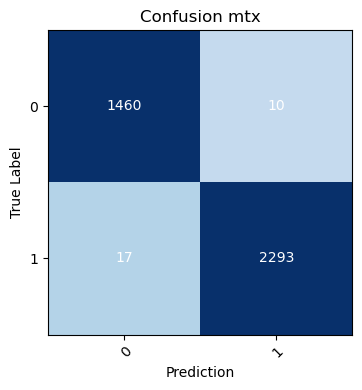

In [25]:
label_ = list(range(2 if target=='gender' else 3))

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(mtx, cmap='Blues', vmax=100, vmin=-20)

ax.set_xticks(np.arange(len(label_)))
ax.set_yticks(np.arange(len(label_)))
# ... and label them with the respective list entries
ax.set_xticklabels(label_)
ax.set_yticklabels(label_)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(label_)):
    for j in range(len(label_)):
        if mtx[i, j]:
            text = ax.text(j, i, mtx[i, j],
                           ha="center", va="center", color="w", size=10)
ax.set_xlabel('Prediction')
ax.set_ylabel('True Label')
ax.set_title("Confusion mtx")
fig.tight_layout()
plt.show()

In [26]:
label_d = {
    'age' : ['< 30', '30~59', ' 60 <='],
    'gender' : ['Male','Female'],
    'mask' : ['Mask', 'Incorrect', 'Normal']
}

iterator = iter(wrong)

label = label_d[target]
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

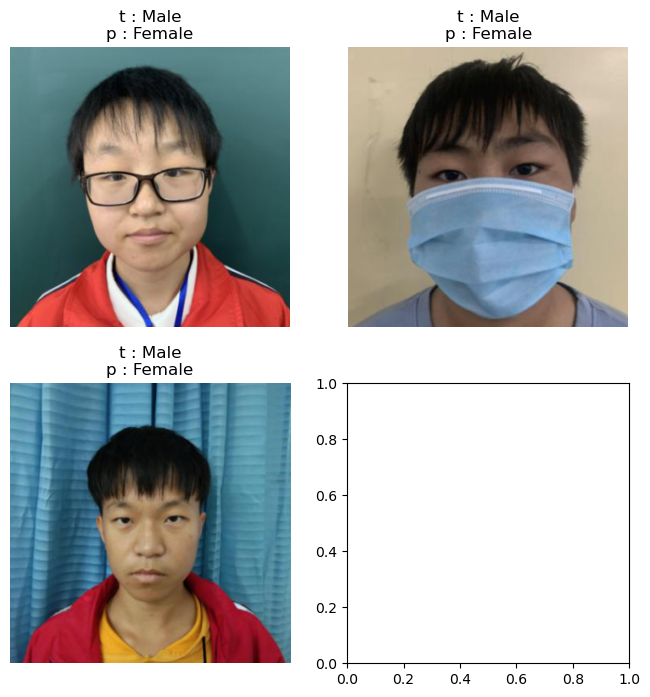

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
for ax in axes.flatten():
    try:
        img, p, t = next(iterator)
    except:
        continue
    img = img.transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f't : {label[t]}\np : {label[p]}')
plt.show()